In [220]:
execfile('../src/display_utils.py')
execfile('../src/moldev_utils.py')
%matplotlib inline

In [221]:
summary = pd.read_csv('../output/condition_summary.csv')

In [222]:
colors = {'Blue & Red':'bwr','Blue':'Blues'}

# Well Plate Results

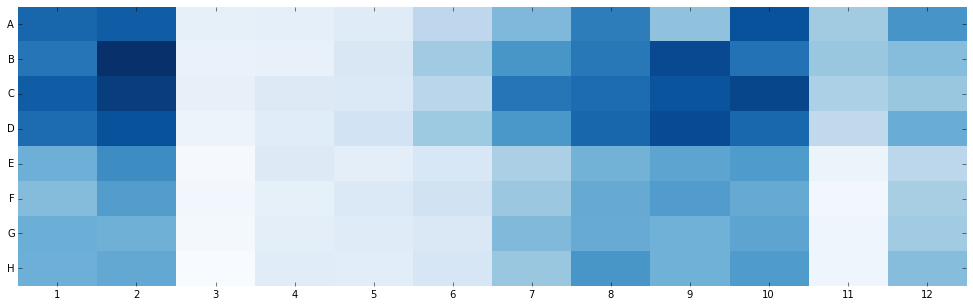

In [223]:
plate_data = pd.read_csv('../output/well_summary.csv')
interact(plot_plate, 
         data = fixed(plate_data),
         parameter = widgets.Select(value = 'Cell Count',
                                    options= get_params(plate_data),
                                    height=250),
         function = plate_data['Function'].unique().tolist(),
         color = colors);

# How do conditions cluster together?

In [224]:
data = pipe(summary,
            get_means,
            lambda df: df.set_index('Condition'),
            normalize_columns)

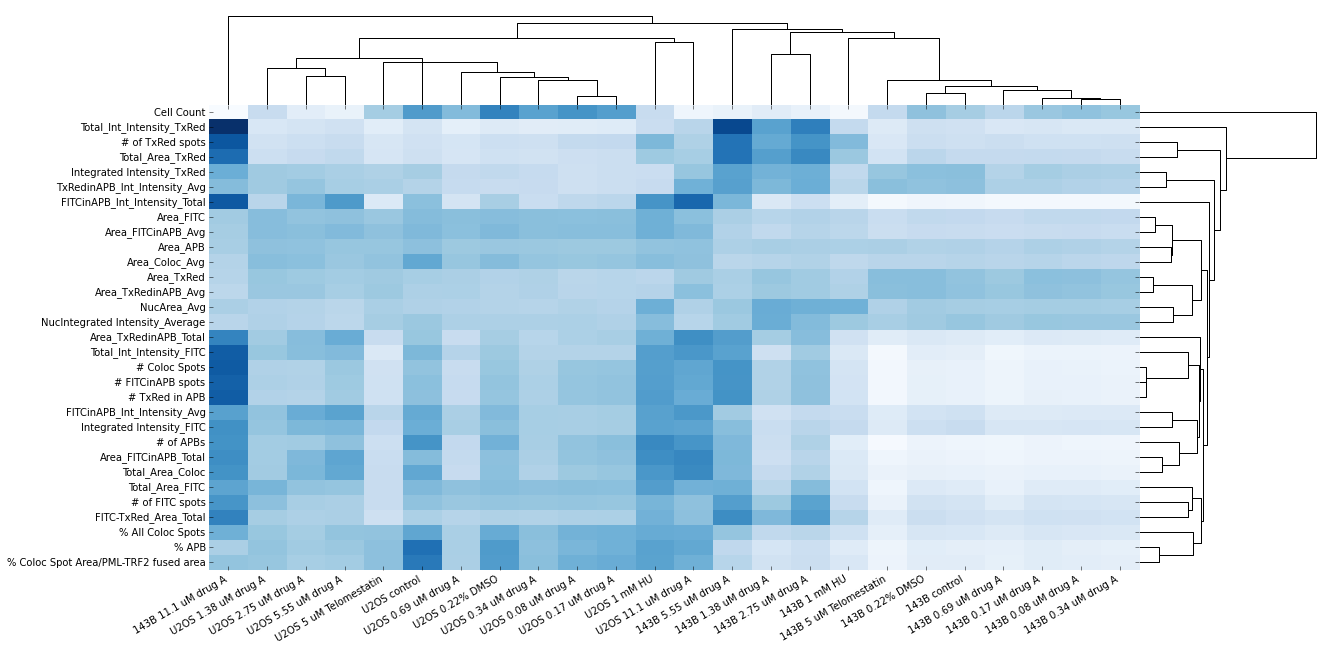

In [225]:
interact(matrix_tree, data = fixed(data), color = colors);

# Heatmap subsets

In [226]:
def wrapper(conditions,features,color):
    df = data.loc[list(conditions)][list(features)]
    try: 
        matrix_tree(df,color)
    except:
        print "\n".join(["-"*50, "Please select multiple features and conditions.","-"*50])

subset = interactive(wrapper,
                     conditions = widgets.SelectMultiple(options = data.index.values.tolist(),height = 300),
                     features = widgets.SelectMultiple(options = data.columns.values.tolist(),height = 300),
                     color = colors)
subset

--------------------------------------------------
Please select multiple features and conditions.
--------------------------------------------------


# How do parameters vary with drug dose?

In [227]:
dose_data = thread_first(summary,
                        lambda df: df[df['Function'] == 'mean'],
                        add_condition_cols)

dose_error = thread_first(summary,
                        lambda df: df[df['Function'] == 'sem'],
                        add_condition_cols)

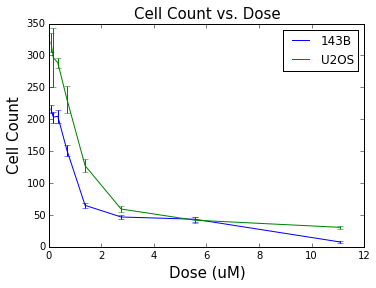

In [228]:
interact(dose_plot,
         scale = widgets.ToggleButtons(options=['linear','log']), 
         df = fixed(dose_data),
         err = fixed(dose_error),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= [col for col in dose_data.columns.values.tolist() if col not in ['Condition','Function','Base','Dose','Unit','Drug']],
                              height=250));

#How are different parameters related?

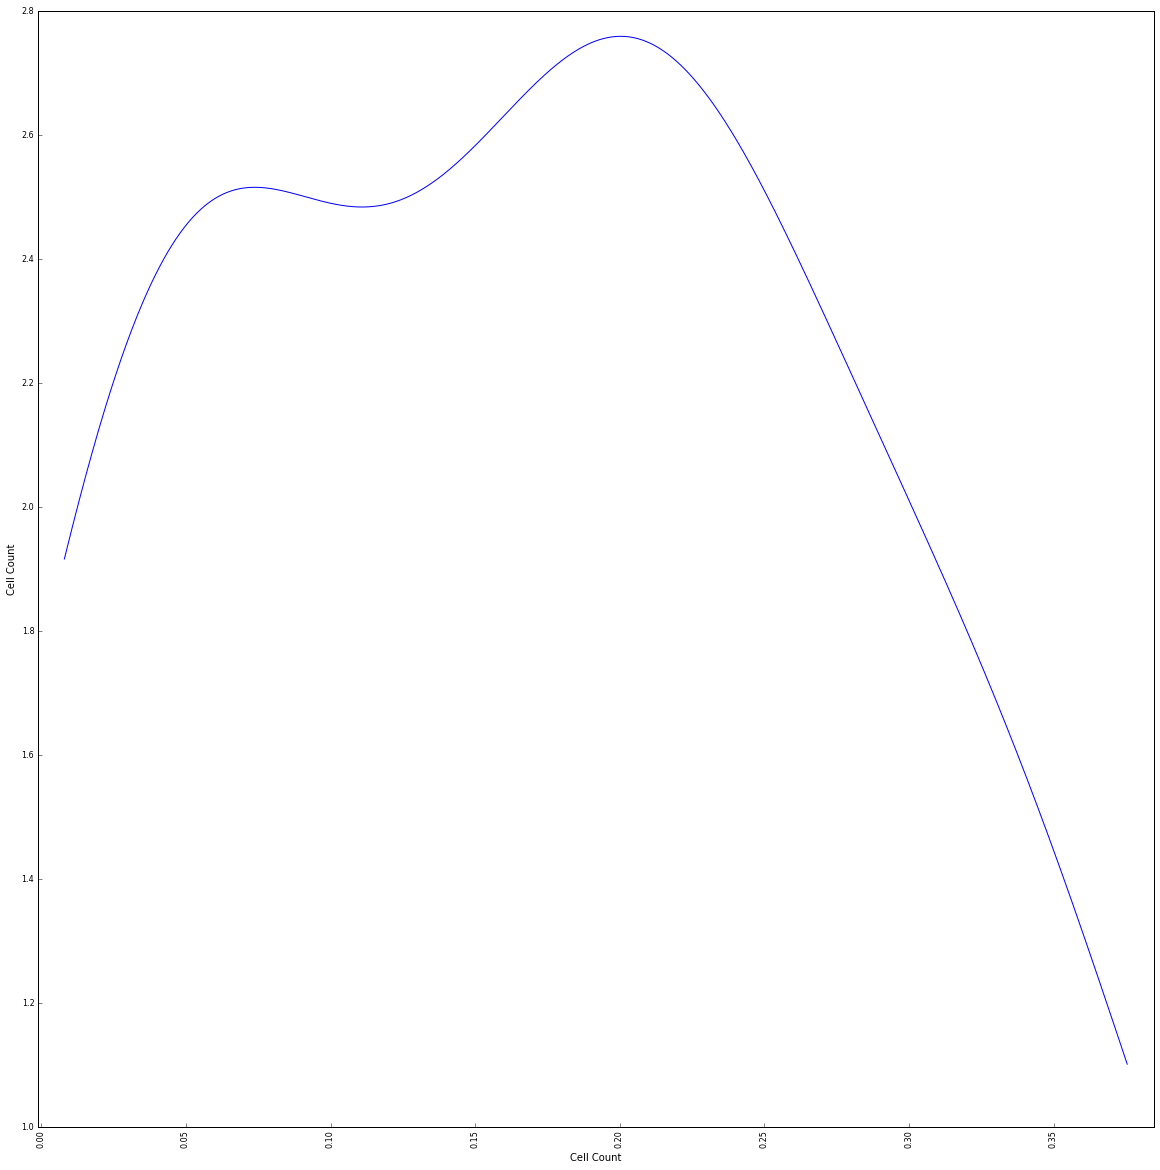

In [229]:
from pandas.tools.plotting import scatter_matrix

def scatter(df,cols):
    scatter_matrix(data[list(cols)], alpha=1, figsize=(20, 20), diagonal='kde');
    
interact(scatter, 
         df = fixed(filter_rows(dose_data,'Base','143B')),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= get_params(dose_data),
                              height=250));

# Parameter vs. Conditions

In [230]:
raw_cell_data = pd.read_csv('../output/moldev_cleaned.csv')
cell_data = add_condition_cols(raw_cell_data)

In [231]:
def plot_dist(df,base,parameter, max_shown=3):
    data = df[df['Base'] == base].sort(['Drug','Dose'])
    plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
    sns.boxplot(data[parameter], 
                data['Condition'],
                vert=False,
                order=data.Condition.unique(),
                color=map(colorize,data.Condition.unique()))
    plt.ylabel('Condition',fontsize=20)
    plt.xlabel(parameter,fontsize=20)
    plt.tick_params(labelsize=20)
    mean = data[parameter].mean()
    plt.gca().set_xlim([0 - mean * (max_shown/10),max_shown * mean])

In [232]:
def get_params(df):
    cols = df.columns.tolist()
    return sorted([col for col in cols if col not in ['Well Name', 'Condition', 'Base', 'Dose', 'Unit', 'Drug','Function']])

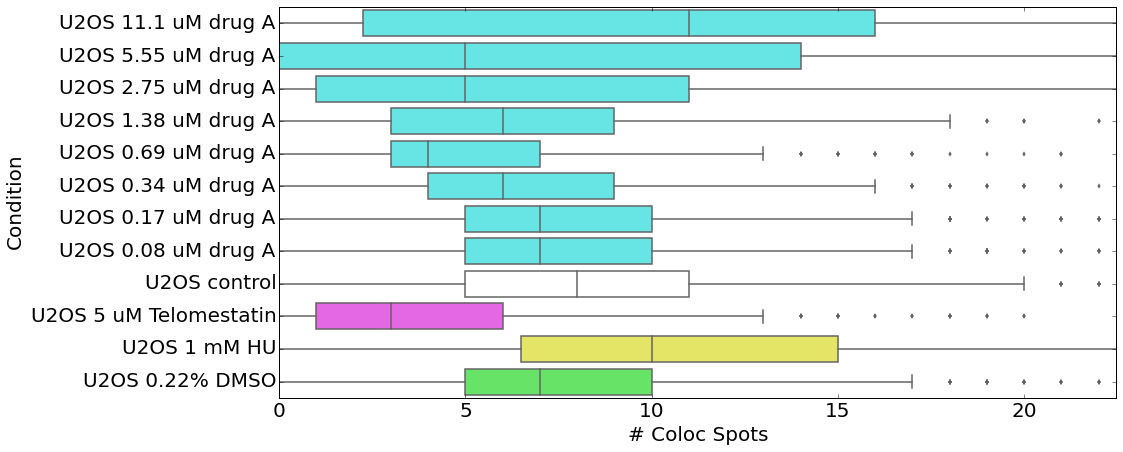

In [233]:
interactive(plot_dist,
            df = fixed(cell_data), 
            base = cell_data.Base.unique().tolist(), 
            parameter = get_params(cell_data))